In [47]:
import numpy as np

A = 1
fr = 5
fs = 100
#fs = 100/1.01010101010101 
N = 100
dt = 1/fs
t = np.arange(N)*dt
x = A*np.sin(2*np.pi*fr*t)

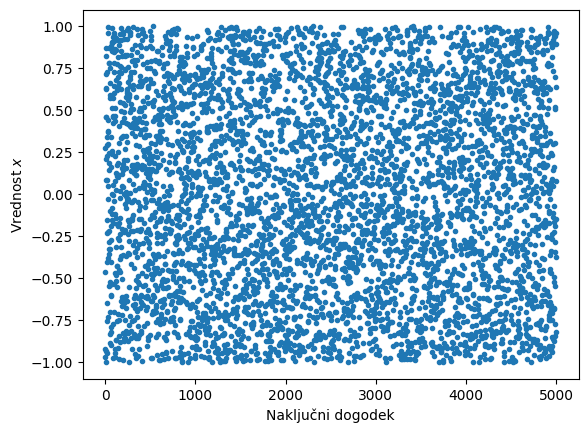

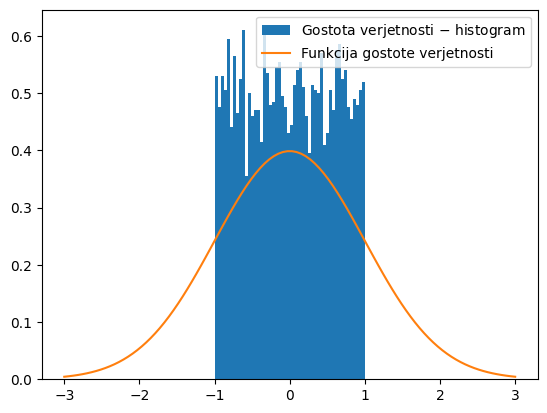

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sym
σ, μ, x, = sym.symbols('\\sigma, \\mu, x', real=True, positive=True)
π = sym.pi

p = 1/(σ*sym.sqrt(2*π)) * sym.exp(-(x-μ)**2/(2*σ**2))
podatki = {σ: 1., μ: 0.}
pdf = sym.lambdify(x, p.subs(podatki))


rng = np.random.default_rng(0)
#x = rng.normal(loc=podatki[μ], scale=podatki[σ], size=5000)
x = rng.uniform(low=-1, high=1, size=5000) # enakomerna porazdelitev
plt.plot(x, '.')
plt.xlabel('Naključni dogodek')
plt.ylabel('Vrednost $x$')
plt.show()

plt.hist(x, bins=50, density=True, label='Gostota verjetnosti $-$ histogram')

x = np.linspace(-3*podatki[σ],3*podatki[σ], 100)
plt.plot(x, pdf(x), label='Funkcija gostote verjetnosti')
plt.legend()
plt.show()

In [49]:
t[-3:]

array([0.97, 0.98, 0.99])

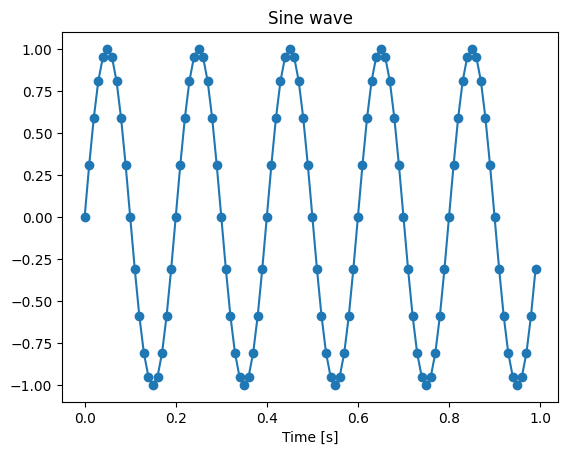

In [48]:
import matplotlib.pyplot as plt
plt.plot(t, x, 'o-')
plt.title('Sine wave')
plt.xlabel('Time [s]');

In [51]:
X = np.fft.fft(x,n=10*N)/N
fr = np.fft.fftfreq(10*N, dt)

In [46]:
X[5]

np.complex128(0.0774915073687238-0.48926212202373875j)

Text(0.5, 1.0, 'FFT of sine wave')

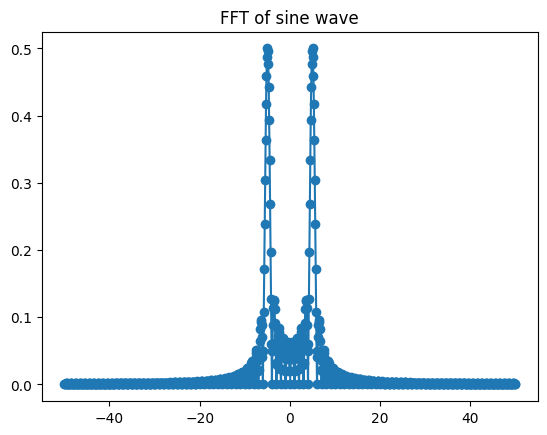

In [53]:
plt.plot(fr, np.abs(X), 'o-')
plt.title('FFT of sine wave')

In [32]:
k=10
X[k]

np.complex128(-5.659255066078717e-15-8.436699329493333e-15j)

In [33]:
fr[k]

np.float64(10.0)

In [34]:
import numpy as np

A = 1
fr = 5
fs = 100 
N = 100
# Spodnja `fs` rezultira v vključenost zadnje točke. Rezultat bo napačen!
#fs = 100/1.01010101010101
dt = 1/fs
t = np.arange(100)*dt
x = A*np.sin(2*np.pi*fr*t)

X_r = np.fft.rfft(x)
freq_r = np.fft.rfftfreq(len(x), d=dt)